In [1]:
## gurobi
## Author: Vishal Arya
## GMU Dept Applied Math/Oper Research, graduate student
import numpy as np
from scipy import stats
import pandas as pd
from scipy.stats import t, sem

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display

import gurobipy as gp
from gurobipy import GRB

import scipy . sparse as sp
from arch import arch_model

import datetime
from datetime import timedelta

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import clear_output

pd.set_option('display.max_columns', None)
pd.set_option("max_rows", 500)


In [2]:
## run proj

#input params
vdata = input("enter csv data file (should be in local directory of Jupyter Notebook) ")
v_alpha = int(input("enter risk aversion parameter alpha (non-negative)"))
v_lookback = int(input("enter lookback period (days)"))
v_adjust = int(input("enter adjustment period for portfolio adjustment"))

enter csv data file (should be in local directory of Jupyter Notebook) data_clean.csv
enter risk aversion parameter alpha (non-negative)1
enter lookback period (days)60
enter adjustment period for portfolio adjustment120


In [3]:
vdata = pd.read_csv(vdata) ##read in data of prices

In [4]:
vdata['close_date'] = pd.to_datetime(vdata['Date'])
vdata['vdate'] = [d.date() for d in vdata['close_date']]


#instantiate opt params
start_wealth = 1000
curdate = datetime.date(2012,1,3)
startperiod = vdata[vdata.vdate == curdate].index[0]
v_lookback = v_lookback - 1


#compute daily per cent change data
pdata = vdata.drop(columns=["Date","close_date","vdate"]) #contains price % change data only
pdata = pdata.pct_change().dropna()

#spdata contains only share price data to compute shares at Time = t
spdata = vdata.drop(columns=["Date","close_date","vdate"]) #contains price data only

#set params for running optimization
nstocks = pdata.shape[1]
ca = np.ones(nstocks).reshape(1,nstocks) #constraint A matrix [1xnumstocks]
endperiod = np.max(pdata.index)

yearsperiod = (vdata.loc[vdata.index == endperiod,"vdate"].iloc[0] - vdata.loc[vdata.index == startperiod,"vdate"].iloc[0]).days/360
vperturb = .000001 #perturbation for covariance matrix numerical error calculation np.cov

In [5]:
#analyze covariance hessian matrix at each adjustment period

def hessian_type(hessian):
    eigenmax = np.max(np.linalg.eig(hessian)[0])
    eigenmin = np.min(np.linalg.eig(hessian)[0])
    
    if (eigenmax >= 0) & (eigenmin >= 0):
        vtype = "positive semi-definite"
    elif (eigenmax > 0) & (eigenmin > 0):
        vtype = "positive definite"
    elif (eigenmax <= 0) & (eigenmin <= 0):
        vtype = "negative semi-definite"
    elif (eigenmax < 0) & (eigenmin < 0):
        vtype = "negative definite"
    else:
        vtype = "indefinite"
    
    cov_COND = np.abs(eigenmax / eigenmin) #compute condition # of covariance matrix Q
    
    return (vtype, cov_COND)


#naive if purchased shares t=504 randomly, held until end period, what is portfolio value
#runs 100 random simulations, computes mean/std error, mean compared against actual portfolio value
naive_wealth = []
nruns = 100
for i in range(nruns):
    nwealth = start_wealth*(np.random.dirichlet(np.ones(nstocks),size=1) @ (np.array(spdata[spdata.index == endperiod]) / np.array(spdata[spdata.index == startperiod])).T)[0][0]
    naive_wealth.append(nwealth)

    
naive_wealth = np.array(naive_wealth)

naive_mean = naive_wealth.mean()
naive_stderr =  naive_wealth.std() / (nruns**.5)
naive_ann_return = (naive_mean  / start_wealth)**(1/yearsperiod) - 1


In [6]:
#implement while loop

GARCHADJUST = 0 # set to 0 to turn OFF GARCH adjustment, set to 1 to turn ON GARCH adjustment

curindex = vdata[vdata.vdate == curdate].index[0]
track_wealth = [(start_wealth, curindex)]
counter = 0
pindex = curindex - 1

v_adjust_list = []

if GARCHADJUST:
    v_adjust_list = ulist
else:
    for i in range(int((endperiod - startperiod) / v_adjust)):
        v_adjust_list.append(startperiod+(i+1)*v_adjust)

track_shares = []
track_hessian = []
greedy_track = [(start_wealth, curindex)]
track_stats = []


## greedy investor calculated (takes long/short positions based on historical performance)
while counter <= len(v_adjust_list):
    #compute mean vector and covariance matrix V
    adj_means = np.array(np.mean(pdata[(pdata.index >= pindex-v_lookback) & (pdata.index <= pindex)],axis=0))
    adj_cov = np.cov(pdata[(pdata.index >= pindex-v_lookback) & (pdata.index <= pindex)], rowvar=False, bias=True)
    
    adj_cov = adj_cov + np.identity(nstocks)*vperturb #correct numerical error precision

    # solve convex optimization for weight vector dec vars x
    m = gp.Model("opt1")
    x = m.addMVar(nstocks, lb=0.0, name="stock")

    m.addConstr(ca @ x == 1 , "c1")
    m.setObjective (adj_means@x - v_alpha*(x @ adj_cov @ x), GRB.MAXIMIZE)

    m.optimize() #optimize adj sharpe ratio maximization problem and compute weight vector x
    
    vpositions = np.array([m.getVars()[i].x for i in range(len(m.getVars()))]) # % allocation per stock
    exp_return = adj_means @ vpositions # get expected return portfolio based on solved port-opt
    exp_risk = (vpositions @ adj_cov @ vpositions)**.5 # get exp std deviation of portfolio
    track_stats.append((exp_return, exp_risk, curindex))
    
    track_hessian.append(hessian_type(adj_cov))
    
    if counter == 0: #get current shares per stock price based on solved opt x vector
        curshares = np.array(vpositions*start_wealth / spdata[spdata.index == curindex])
        
        greedy_means = np.array([-1 if i < 0 else i for i in adj_means])
        greedy_means = np.array([1 if i > 0 else i for i in greedy_means])
        greedy_means = greedy_means.reshape(1,nstocks) #contains 1 for long, -1 for short
        
        greedy_shares = np.array((np.abs(adj_means) / np.sum(np.abs(adj_means))*start_wealth).reshape(1,nstocks) * greedy_means / spdata[spdata.index == curindex]).reshape(1,nstocks)
        #hadamard product to determine long/short share positions greedy
        
    else:
        #get current portfolio value (ie sell old positions)
        curvalue = (curshares @ np.array(spdata[spdata.index == curindex]).T)[0][0] # port value
        track_wealth.append((curvalue, curindex))
        #get total # of new shares per stock (ie take new positions)
        curshares = np.array(vpositions*curvalue / spdata[spdata.index == curindex])
        
        #track greedy port value
        greedyvalue = (greedy_shares @ (np.array(spdata[spdata.index == curindex] - np.array(spdata[spdata.index == lastindex]))).T)[0][0] # port value
        greedyvalue = greedyvalue + greedy_track[counter-1][0] # greedyvalue[t] = delta_value + value(t-1)
        greedy_track.append((greedyvalue, curindex))
        
        greedy_means = np.array([-1 if i < 0 else i for i in adj_means])
        greedy_means = np.array([1 if i > 0 else i for i in greedy_means])
        greedy_means = greedy_means.reshape(1,nstocks) #contains 1 for long, -1 for short
        
        greedy_shares = np.array((np.abs(adj_means) / np.sum(np.abs(adj_means))*greedyvalue).reshape(1,nstocks) * greedy_means / spdata[spdata.index == curindex]).reshape(1,nstocks)
        #hadamard product to determine long/short share positions greedy
        
           
    counter = counter + 1
    lastindex = curindex
    if(counter > len(v_adjust_list)):
        break
    
    curindex = v_adjust_list[counter-1]
    pindex = curindex - 1


#get ending period port value for comparisons
curvalue = (curshares @ np.array(spdata[spdata.index == endperiod]).T)[0][0] # port value
track_wealth.append((curvalue, endperiod))

greedyvalue = (greedy_shares @ (np.array(spdata[spdata.index == endperiod] - np.array(spdata[spdata.index == lastindex]))).T)[0][0] # port value
greedyvalue = greedyvalue + greedy_track[counter-1][0] # greedyvalue[t] = delta_value + value(t-1)
greedy_track.append((greedyvalue, endperiod))

Using license file /home/aryavish/gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-08


<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x6f54b109
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 9e-03]
  QObjective range [6e-08, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.09570954e+05  3.29049728e+05  1.53e+05 1.29e+00  1.00e+06     0s
   1  -4.2

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x65344daa
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e-02]
  QObjective range [1e-08, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.41916716e+05  3.10290041e+05  1.10e+05 4.20e-01  1.00e+06     0s
   1  -7.5

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x67a6636d
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 1e-02]
  QObjective range [2e-09, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.04074138e+05  3.04292141e+05  1.32e+05 5.18e-01  1.00e+06     0s
   1  -7.6

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x189b2275
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e-02]
  QObjective range [3e-09, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.67911411e+05  3.08317228e+05  1.08e+05 9.34e-01  1.00e+06     0s
   1  -5.0

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0xa641a332
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 6e-03]
  QObjective range [6e-09, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.37280622e+05  3.35525292e+05  1.77e+05 1.63e+00  1.00e+06     0s
   1  -4.8

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x4a3501a6
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 5e-03]
  QObjective range [4e-09, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.68445008e+05  2.85934755e+05  1.43e+05 4.81e-01  1.00e+06     0s
   1  -6.0

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x18af1e0b
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-07, 7e-03]
  QObjective range [3e-09, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.53235795e+05  2.96794733e+05  1.41e+05 6.34e-01  1.00e+06     0s
   1  -4.8

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x31d58796
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 5e-03]
  QObjective range [9e-09, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.66956797e+05  2.84997070e+05  1.05e+05 4.57e-01  1.00e+06     0s
   1  -7.5

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x58e1b2c1
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-06, 8e-03]
  QObjective range [4e-07, 7e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.82887894e+05  2.72498183e+05  1.03e+05 4.43e-01  1.00e+06     0s
   1  -8.4

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x48d8de7a
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-06, 2e-02]
  QObjective range [2e-09, 9e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.04630728e+05  2.73648520e+05  1.58e+05 1.23e+00  1.00e+06     0s
   1  -1.0

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x2aed9a4d
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-06, 6e-03]
  QObjective range [3e-09, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.87257034e+05  2.90900489e+05  1.66e+05 8.68e-01  1.00e+06     0s
   1  -6.0

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x942398d8
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-06, 6e-03]
  QObjective range [1e-09, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.03s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.47381008e+05  2.91882759e+05  1.23e+05 9.57e-01  1.00e+06     0s
   1  -6.0

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x76c34160
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 6e-03]
  QObjective range [2e-09, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.03s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.67560440e+05  2.86951956e+05  1.47e+05 4.99e-01  1.00e+06     0s
   1  -1.0

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0xbfb1d857
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 9e-03]
  QObjective range [5e-09, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.63777113e+05  2.80313365e+05  1.37e+05 8.44e-01  1.00e+06     0s
   1  -6.2

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0xceab1414
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e-02]
  QObjective range [1e-09, 4e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.60007273e+05  2.83756836e+05  7.72e+04 5.87e-01  1.00e+06     0s
   1  -7.2

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x2e9d5557
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 6e-03]
  QObjective range [9e-08, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.03s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.47914304e+05  2.75064057e+05  1.17e+05 5.98e-01  1.00e+06     0s
   1  -6.3

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0xd19efd90
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-06, 9e-03]
  QObjective range [7e-10, 4e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.03s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.65242704e+05  2.91065329e+05  1.17e+05 9.61e-01  1.00e+06     0s
   1  -3.8

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x1e7c86d1
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 7e-03]
  QObjective range [1e-09, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.04s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.27226903e+05  2.76335658e+05  1.41e+05 6.90e-01  1.00e+06     0s
   1  -7.7

<(1,) matrix constraint>

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 448 columns and 448 nonzeros
Model fingerprint: 0x75fd8b59
Model has 100576 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-07, 2e-02]
  QObjective range [8e-09, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.05s
Presolved: 1 rows, 448 columns, 448 nonzeros
Presolved model has 100576 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 447
 AA' NZ     : 1.001e+05
 Factor NZ  : 1.006e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.007e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.10709808e+05  2.86004076e+05  9.38e+04 9.53e-01  1.00e+06     0s
   1  -6.3

In [7]:
track_hessian # prints convexity type of cov matrix and condition Q at each adjustment period

[('positive semi-definite', 169155.11552953176),
 ('positive semi-definite', 62742.614042284375),
 ('positive semi-definite', 27168.466705422037),
 ('positive semi-definite', 36609.48694009256),
 ('positive semi-definite', 22900.21304872296),
 ('positive semi-definite', 29134.70634854739),
 ('positive semi-definite', 35206.52766097265),
 ('positive semi-definite', 23749.016572663317),
 ('positive semi-definite', 84813.09786340107),
 ('positive semi-definite', 68569.85909103254),
 ('positive semi-definite', 21730.135856351506),
 ('positive semi-definite', 13988.728551464457),
 ('positive semi-definite', 13134.76826400808),
 ('positive semi-definite', 47568.479065597836),
 ('positive semi-definite', 14764.45738532975),
 ('positive semi-definite', 77162.38949505531),
 ('positive semi-definite', 46477.30776128911),
 ('positive semi-definite', 23934.921120287738),
 ('positive semi-definite', 217635.62454758325)]

In [8]:
statsdf = pd.DataFrame(track_stats, columns = ["exp_return","std_dev","period"])

statsdf['tot_return'] = 1 + statsdf.exp_return
statsdf['tot_percent'] = statsdf.tot_return.cumprod()

exp_wealth = [start_wealth]

exp_wealth.extend([(statsdf.tot_percent*1000)[x] for x in range((statsdf.tot_percent*1000).shape[0])])

statsdf

,exp_return,std_dev,period,tot_return,tot_percent
0,0.008699,0.032161,504,1.008699,1.008699
1,0.009530,0.038775,624,1.009530,1.018311
2,0.009601,0.046889,744,1.009601,1.028088
3,0.008697,0.036509,864,1.008697,1.037030
4,0.006352,0.011472,984,1.006352,1.043617
5,0.003417,0.015648,1104,1.003417,1.047183
6,0.005525,0.023465,1224,1.005525,1.052968
7,0.004967,0.019320,1344,1.004967,1.058198
8,0.006267,0.026036,1464,1.006267,1.064829
9,0.020871,0.065993,1584,1.020871,1.087054


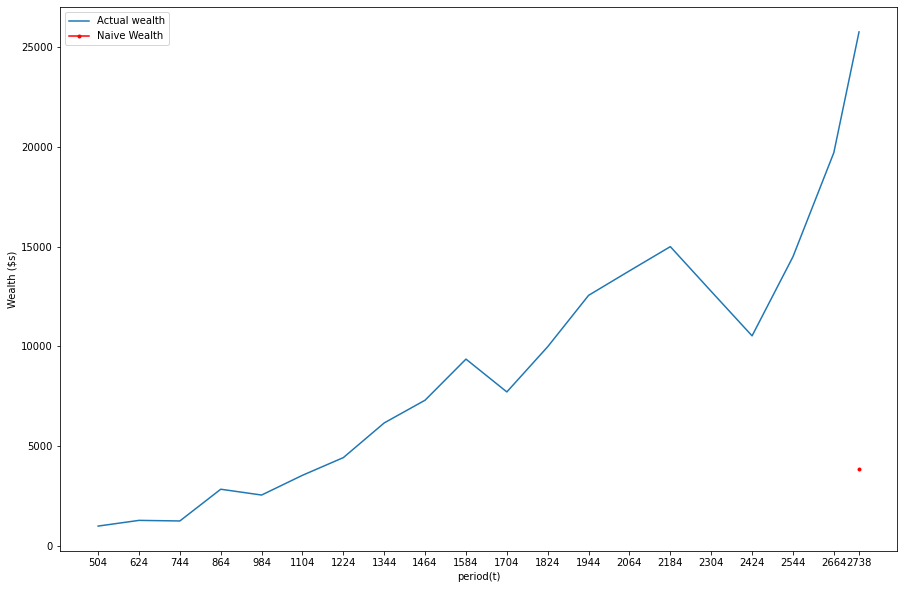

In [9]:
trackdf = pd.DataFrame(track_wealth, columns = ["endprice", "period"])
#greedydf = pd.DataFrame(greedy_track, columns = ["endprice", "period"])

#plot price curve
plt.figure(figsize=(15,10))
plt.plot(trackdf.period,trackdf.endprice, label="Actual wealth")
#plt.plot(greedydf.period, greedydf.endprice, label="Greedy wealth")
plt.xlabel('period(t)')
plt.ylabel(r'Wealth ($s)')
plt.xticks(trackdf.period)
plt.plot([endperiod], [naive_mean], marker='o', markersize=3, color="red", label="Naive Wealth")
plt.legend(loc='upper left')

clear_output()


In [10]:
trackdf

,endprice,period
0,1000.000000,504
1,1286.186194,624
2,1256.907688,744
3,2846.424731,864
4,2555.442130,984
5,3544.895981,1104
6,4430.571155,1224
7,6168.114667,1344
8,7306.072129,1464
9,9363.794960,1584


In [11]:
totreturn = trackdf.iloc[trackdf.shape[0]-1,0] / trackdf.iloc[0,0]
annreturn = totreturn**(1/(yearsperiod)) - 1

print("SUMMARY RESULTS \n================\n================\n")
print ("Total end period wealth $%d and tot increase return %f " % (trackdf.iloc[trackdf.shape[0]-1,0],totreturn-1))

print("\nCompounded actual annual return: %f " % annreturn)

print("\nNaive ending portfolio value $%d and naive cmpd ann return %f" % (naive_mean,naive_ann_return))

print("\nInput params are alpha: %d lookback(days): %d adjustment(days): %d" % (v_alpha, v_lookback+1, v_adjust))

SUMMARY RESULTS 

Total end period wealth $25752 and tot increase return 24.752606 

Compounded actual annual return: 0.434530 

Naive ending portfolio value $3861 and naive cmpd ann return 0.161916

Input params are alpha: 1 lookback(days): 60 adjustment(days): 120


Sharpe value actual: 0.687643


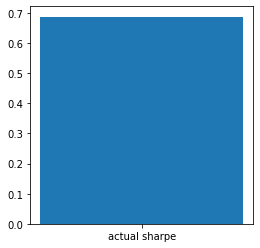

In [12]:
actualsharpe = trackdf.endprice.pct_change().dropna().mean() / trackdf.endprice.pct_change().dropna().std()

plt.figure(figsize=(4,4))
xlist = ["actual sharpe"]
plt.bar(xlist, [actualsharpe])
clear_output()

print("Sharpe value actual: %f" % (actualsharpe))


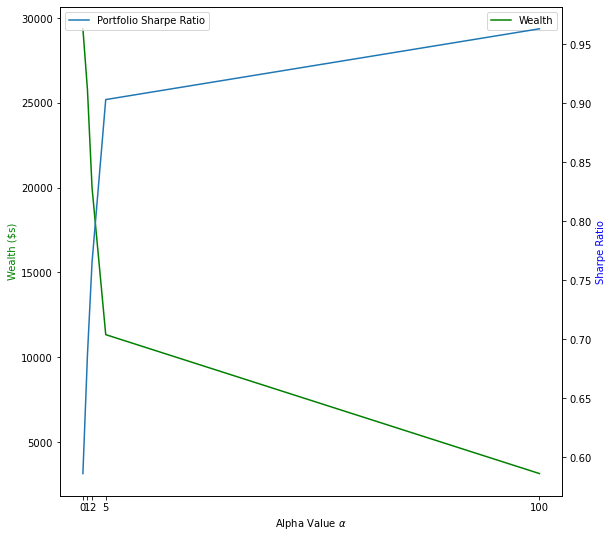

In [13]:
#print alpha graph

#data
#fixed params (days): lookback = 60; adjust = 120

graph_alpha = pd.DataFrame([(0,29357,0.586),
(1,25752,0.687),
(2,20000,0.765),
(5,11333,0.903),
(100,3146,0.963)], columns=["alpha","wealth","sharpe"])

fig, ax1 = plt.subplots(figsize=(9,9))

ax2 = ax1.twinx()

ax1.plot(graph_alpha.alpha,graph_alpha.wealth,  color='g', label="Wealth")

ax2.plot(graph_alpha.alpha,graph_alpha.sharpe, label="Portfolio Sharpe Ratio")

ax1.set_xlabel(r'Alpha Value $\alpha$')
plt.xticks(graph_alpha.alpha)
ax1.set_ylabel('Wealth ($s)', color='g')
ax2.set_ylabel('Sharpe Ratio', color='b')
ax1.legend(loc="best")
ax2.legend(loc="best")
clear_output()
plt.show()


In [14]:
#GARCH estimation params

garchshares = np.ones(nstocks).reshape(1,nstocks)*(start_wealth/nstocks)

garchshares = garchshares / np.array(spdata[spdata.index == 0]) #hardamard product to get shares at time t = 0

garchportvalue_tot = [(garchshares @ np.array(spdata[spdata.index == x]).T)[0][0] for x in range(endperiod)]

garchportvalue_tot = np.array(garchportvalue_tot)

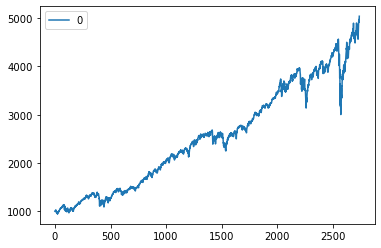

In [15]:
pd.DataFrame(garchportvalue_tot).plot() #plot overall market trajectory in data

In [16]:
garchportvalue = [(garchshares @ np.array(spdata[spdata.index == x]).T)[0][0] for x in range(startperiod)]

garchportvalue = np.array(garchportvalue)

garchpvaluezstd = (garchportvalue - garchportvalue.mean()) / garchportvalue.std()

In [17]:
#create garch model

gmodel = arch_model(garchportvalue, vol='GARCH', p=1, o=0, q=1)
gmodel.fit()

/home/aryavish/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.488e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 14500.913117602628
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2996.038809089466
Iteration:      3,   Func. Count:     18,   Neg. LLF: 2993.5509906602892
Iteration:      4,   Func. Count:     23,   Neg. LLF: 2993.425928830234
Iteration:      5,   Func. Count:     28,   Neg. LLF: 2993.2882570919573
Iteration:      6,   Func. Count:     33,   Neg. LLF: 2993.258756339268
Iteration:      7,   Func. Count:     38,   Neg. LLF: 2993.139737065216
Iteration:      8,   Func. Count:     43,   Neg. LLF: 2993.0892348494353
Iteration:      9,   Func. Count:     48,   Neg. LLF: 2993.0769572009885
Iteration:     10,   Func. Count:     53,   Neg. LLF: 2993.0240131679766
Iteration:     11,   Func. Count:     58,   Neg. LLF: 2992.98431370394
Iteration:     12,   Func. Count:     63,   Neg. LLF: 2992.9842526306984
Iteration:     13,   Func. Count:     68,   Neg. LLF: 2992.9841995440656
Iteration:     14,   Func. Count:     73,   Neg. LLF: 299

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.003
Mean Model:             Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -2992.66
Distribution:                  Normal   AIC:                           5993.33
Method:            Maximum Likelihood   BIC:                           6010.22
                                        No. Observations:                  504
Date:                Sun, Dec 13 2020   Df Residuals:                      500
Time:                        00:08:01   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          1181.9430     13.482     87.670      0.000 [1.

In [18]:
g_omega = 197.7225
g_alpha = 0.6888
g_beta = 0.2985
g_y = 1-g_alpha - g_beta
g_longvar = g_omega / (1-g_alpha - g_beta)

#verify if GARCH historic std fits historical data

print("abs accuracy (difference) std deviation GARCH on data %f " % ((g_omega / (1-g_alpha - g_beta))**.5 - garchportvalue.std()))

abs accuracy (difference) std deviation GARCH on data 2.801832 


In [19]:
#estimate daily volatiltiy starting at t=504

garch_track = [(0,0)]

for i in range(endperiod - startperiod):
    garch_track.append((startperiod + i,(g_omega + g_alpha*(garchportvalue_tot[startperiod + i] - garchportvalue_tot[startperiod + i -1])**2 + \
                       g_beta*(garch_track[i][1]))))
garch_track.pop(0)

(0, 0)

In [20]:
gdf = pd.DataFrame(garch_track, columns=["period","volatility"]) #volatility = variance
gdf['absperchange'] = np.abs(gdf.volatility.pct_change())
gdf['fivedayMA'] = gdf.iloc[:,1].rolling(window=5).mean()

gdf

,period,volatility,absperchange,fivedayMA
0,504,311.188478,NaN,NaN
1,505,290.734355,0.065729,NaN
2,506,333.448871,0.146919,NaN
3,507,298.315868,0.105362,NaN
4,508,297.385373,0.003119,306.214589
...,...,...,...,...
2229,2733,687.837813,0.557267,3892.929609
2230,2734,1205.539545,0.752651,2713.204584
2231,2735,3103.405525,1.574288,1809.858732
2232,2736,4743.649613,0.528530,2258.809845


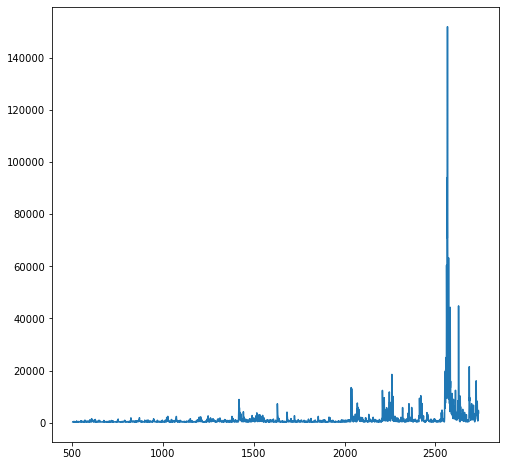

In [21]:
plt.figure(figsize=(8,8))
plt.plot(gdf.period, gdf.volatility)
clear_output()

In [22]:
gdf.fivedayMA.describe()

count     2230.000000
mean      1497.826723
std       4736.749709
min        286.579752
25%        426.598903
50%        593.145003
75%       1018.623989
max      87132.394364
Name: fivedayMA, dtype: float64

In [23]:
np.array(gdf[gdf.fivedayMA >= 800].period) #take highest volatility ~70% quantile

array([ 611,  612,  825,  826,  827,  828,  871,  872,  873,  874,  875,
        949,  950,  951,  953, 1022, 1023, 1024, 1025, 1026, 1027, 1028,
       1029, 1030, 1031, 1032, 1071, 1073, 1074, 1075, 1076, 1077, 1078,
       1191, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1208,
       1209, 1210, 1211, 1212, 1213, 1245, 1246, 1247, 1248, 1249, 1250,
       1251, 1252, 1253, 1261, 1262, 1263, 1264, 1265, 1266, 1271, 1272,
       1275, 1277, 1278, 1279, 1280, 1281, 1303, 1304, 1305, 1306, 1307,
       1308, 1309, 1310, 1311, 1315, 1316, 1317, 1318, 1342, 1343, 1344,
       1380, 1381, 1382, 1383, 1384, 1388, 1389, 1390, 1391, 1392, 1402,
       1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427,
       1428, 1429, 1430, 1431, 1432, 1433, 1434, 1437, 1438, 1439, 1440,
       1441, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452,
       1453, 1477, 1478, 1479, 1480, 1481, 1482, 1490, 1491, 1492, 1493,
       1494, 1495, 1496, 1497, 1498, 1499, 1500, 15

In [24]:
#define 5day MA points for re-adjustment based on manual inspection, can be augmented to automatic updates easily
ulist = [612,828,953,1073,1200,1315,1422,1514,1635,1858,2080, 1920, 2160, 2232, 2383, 2453,2552,2600,2702]

len(ulist)

19

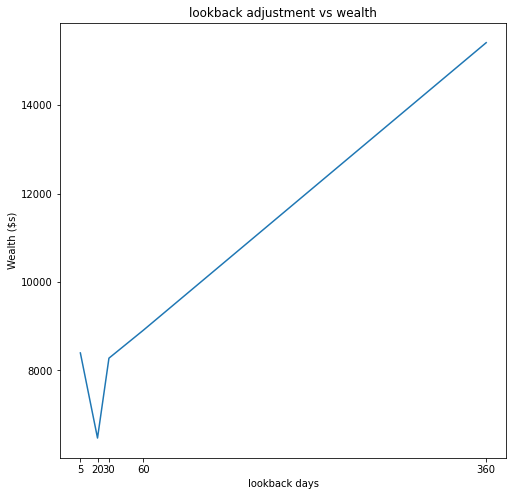

In [25]:
#lookback graph, adjustment = 60 days, alpha = 1

data_lookback = [(5,8395,0.48),
(20,6471,0.35),
(30,8277,0.37),
(60,8907,0.36),
(360,15411,0.57)]

lookbackdf = pd.DataFrame(data_lookback, columns=["lookback","wealth","sharpe"])

lookbackdf

plt.figure(figsize=(8,8))
plt.plot(lookbackdf.lookback, lookbackdf.wealth)
plt.xticks(lookbackdf.lookback)
plt.xlabel("lookback days")
plt.ylabel("Wealth ($s)")
plt.title("lookback adjustment vs wealth")
clear_output()


In [26]:
#adjustment performance data (adjustment period, lookback period, wealth)

data_adjustment = [
('garch',30,9051),
('garch',60,15000),
('garch',10,3738),
('garch',5,960),
('garch',360,10144),
('garch',90,20500),
('170',60,10233),
('170',30,22046),
('170',10,8963),
('170',90,12559),
('120',60,25752),
('120',30,6656),
('360',60,2881),
('360',30,1452),
('120',360,15135),
('170',360,15875),
('360',360,8187)
]

adjustmentdf = pd.DataFrame(data_adjustment, columns=["adjust_type","lookback","wealth"])
adjustmentdf.sort_values(['adjust_type', 'lookback'], ascending=[True, True], inplace=True)

adjustmentdf

,adjust_type,lookback,wealth
11,120,30,6656
10,120,60,25752
14,120,360,15135
8,170,10,8963
7,170,30,22046
6,170,60,10233
9,170,90,12559
15,170,360,15875
13,360,30,1452
12,360,60,2881


Text(0, 0.5, 'Wealth ($s)')

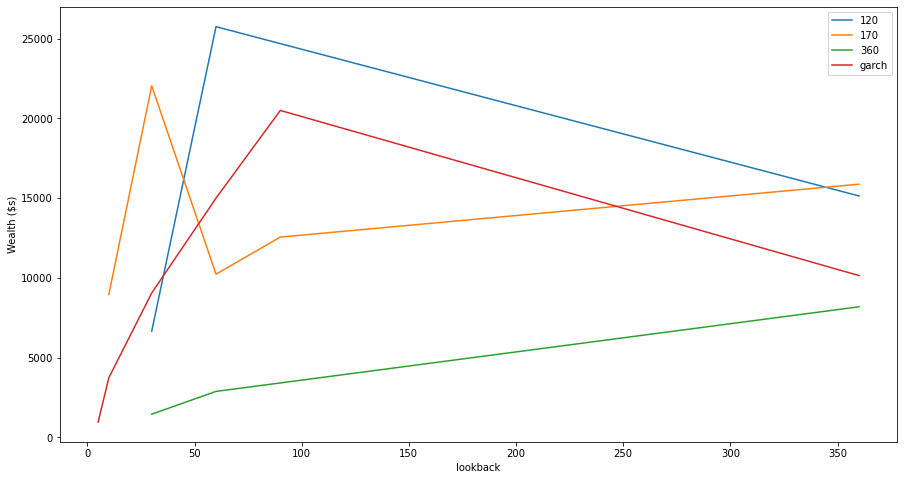

In [27]:
fig, ax = plt.subplots(figsize=(15,8))

for key, grp in adjustmentdf.groupby(['adjust_type']):
    ax = grp.plot(ax=ax, kind='line', x='lookback', y='wealth', label=key)

ax.set_ylabel('Wealth ($s)', color='black')
plt.legend(loc='best')
plt.show()

In [28]:
print("[[Model completed successfully]]")

[[Model completed successfully]]
